In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, pearson, acc, nomean

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
EPOCHS = 100
LR = 1e-3
BATCH_SIZE = 2048
EMBED_DIM = 256

In [4]:
ds = AGNEWS()

In [5]:
# train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE)
# model = TextClassificationModel(embed_dim = EMBED_DIM).to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = LR)

In [6]:
# log = []
# for epoch in tqdm(range(EPOCHS)):
#     loss_train = train(model, train_loader, criterion, optimizer)
#     loss_eval = eval(model, val_loader, criterion)
#     # print(loss_train, loss_eval)
#     log.append([loss_train, loss_eval])
# plt.plot(log);
# eval(model, test_loader, criterion), acc(model, test_loader)

In [7]:
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = True)
model = zip_ssl(embed_dim = EMBED_DIM).to(device)

criterion = pearson
# criterion = nomean
optimizer = optim.Adam(model.parameters(), lr = LR)

In [8]:
log = []
for epoch in tqdm(range(EPOCHS)):
    loss_train = train(model, train_loader, criterion, optimizer, ssl = True)
    loss_eval = eval(model, val_loader, criterion, ssl = True)
    print(loss_train, loss_eval)
    log.append([loss_train, loss_eval])

  1%|          | 1/100 [00:09<15:44,  9.54s/it]

0.0002665199540686189 0.0002150460183620453


  2%|▏         | 2/100 [00:19<15:34,  9.54s/it]

0.00015046488820460804 8.910762270291647e-05


  3%|▎         | 3/100 [00:28<15:25,  9.54s/it]

5.063666076513759e-05 2.4398791758964458e-05


  4%|▍         | 4/100 [00:38<15:15,  9.53s/it]

-4.375672090406481e-06 -2.9580353448788325e-05


  5%|▌         | 5/100 [00:47<15:05,  9.53s/it]

-3.538083905158074e-05 -3.191930179794629e-05


  6%|▌         | 6/100 [00:57<14:58,  9.56s/it]

-5.9304089791942063e-05 -5.428543562690417e-05


  7%|▋         | 7/100 [01:06<14:47,  9.55s/it]

-7.88756577592147e-05 -8.355088531970978e-05


  8%|▊         | 8/100 [01:16<14:37,  9.53s/it]

-9.358275988907145e-05 -8.336740483840307e-05


  9%|▉         | 9/100 [01:25<14:26,  9.52s/it]

-0.00010354880152041453 -0.00010748866448799769


 10%|█         | 10/100 [01:35<14:15,  9.51s/it]

-0.00011266414873432694 -0.00011059649288654328


 11%|█         | 11/100 [01:44<14:05,  9.50s/it]

-0.00012480092950557407 -0.00010748721907536189


 12%|█▏        | 12/100 [01:54<13:57,  9.52s/it]

-0.00013408293836472327 -0.00011495327949523926


 13%|█▎        | 13/100 [02:03<13:46,  9.51s/it]

-0.00014314945761049002 -0.00012602970749139785


 14%|█▍        | 14/100 [02:13<13:36,  9.50s/it]

-0.00014523645555763914 -0.00012315165003140766


 15%|█▌        | 15/100 [02:22<13:27,  9.50s/it]

-0.00015407730691265642 -0.00012473121285438537


 16%|█▌        | 16/100 [02:32<13:17,  9.49s/it]

-0.00015897754645138456 -0.00012617818017800648


 17%|█▋        | 17/100 [02:41<13:08,  9.50s/it]

-0.00016623197090730331 -0.0001388030250867208


 18%|█▊        | 18/100 [02:51<12:57,  9.49s/it]

-0.00017242142453528287 -0.00014156282196442287


 19%|█▉        | 19/100 [03:00<12:46,  9.46s/it]

-0.000177247886856397 -0.0001567512849966685


 20%|██        | 20/100 [03:10<12:35,  9.44s/it]

-0.00018219863610309468 -0.0001605602651834488


 21%|██        | 21/100 [03:19<12:25,  9.43s/it]

-0.00018845559133772266 -0.0001465492695569992


 22%|██▏       | 22/100 [03:28<12:15,  9.43s/it]

-0.00019144516895737565 -0.00016401633620262147


 23%|██▎       | 23/100 [03:38<12:07,  9.44s/it]

-0.00019484442054179676 -0.0001632617066303889


 24%|██▍       | 24/100 [03:47<11:57,  9.44s/it]

-0.0002007429733088142 -0.00015787998338540396


 25%|██▌       | 25/100 [03:57<11:47,  9.43s/it]

-0.00020267762557456368 -0.00015899112820625305


 26%|██▌       | 26/100 [04:06<11:38,  9.44s/it]

-0.00020930678959478412 -0.0001600036770105362


 27%|██▋       | 27/100 [04:16<11:29,  9.45s/it]

-0.00021426250877087577 -0.00016205027202765147


 28%|██▊       | 28/100 [04:25<11:20,  9.45s/it]

-0.00021688407032113325 -0.00017033662895361582


 29%|██▉       | 29/100 [04:35<11:10,  9.45s/it]

-0.0002226022442704753 -0.00015438123792409897


 30%|███       | 30/100 [04:44<11:00,  9.44s/it]

-0.00022626710251757973 -0.0001672806094090144


 31%|███       | 31/100 [04:53<10:50,  9.43s/it]

-0.0002305045117411697 -0.00017440034945805867


 32%|███▏      | 32/100 [05:03<10:41,  9.44s/it]

-0.00023238140972037065 -0.00016681583722432454


 33%|███▎      | 33/100 [05:12<10:33,  9.46s/it]

-0.00023870045051240085 -0.00015868498881657918


 34%|███▍      | 34/100 [05:22<10:24,  9.46s/it]

-0.00024461683291092254 -0.00016612769663333892


 35%|███▌      | 35/100 [05:31<10:15,  9.48s/it]

-0.0002493367699677484 -0.0001656989206870397


 36%|███▌      | 36/100 [05:41<10:05,  9.47s/it]

-0.0002571012615634684 -0.00016525651017824808


 37%|███▋      | 37/100 [05:50<09:56,  9.47s/it]

-0.00026248604399070407 -0.00016319766143957774


 38%|███▊      | 38/100 [06:00<09:46,  9.47s/it]

-0.0002659725034446047 -0.00015747280418872833


 39%|███▉      | 39/100 [06:09<09:37,  9.47s/it]

-0.0002750963963437499 -0.0001627595474322637


 40%|████      | 40/100 [06:19<09:28,  9.47s/it]

-0.0002815052380687312 -0.00016337178150812784


 41%|████      | 41/100 [06:28<09:19,  9.49s/it]

-0.0002886055807272593 -0.00015278920531272889


 42%|████▏     | 42/100 [06:38<09:09,  9.48s/it]

-0.000295472559698841 -0.000138572891553243


 43%|████▎     | 43/100 [06:47<09:00,  9.48s/it]

-0.00030548987524551256 -0.0001376200964053472


 44%|████▍     | 44/100 [06:57<08:50,  9.48s/it]

-0.00030989503233056317 -0.00012966316441694896


 45%|████▌     | 45/100 [07:06<08:41,  9.48s/it]

-0.0003167678562172672 -0.000123440017302831


 46%|████▌     | 46/100 [07:16<08:31,  9.48s/it]

-0.00032414072229151143 -0.00011537849406401316


 47%|████▋     | 47/100 [07:25<08:23,  9.50s/it]

-0.00033019490566170006 -0.00010410542537768682


 48%|████▊     | 48/100 [07:35<08:13,  9.49s/it]

-0.00033778014988229986 -8.699488888184229e-05


 49%|████▉     | 49/100 [07:44<08:03,  9.49s/it]

-0.0003443232806105363 -0.00010153588652610778


 50%|█████     | 50/100 [07:53<07:54,  9.48s/it]

-0.00034899361666880155 -8.063444619377454e-05


 51%|█████     | 51/100 [08:03<07:44,  9.49s/it]

-0.00035582193366268225 -8.192148059606553e-05


 52%|█████▏    | 52/100 [08:12<07:35,  9.48s/it]

-0.00036060852282925656 -6.308002894123396e-05


 53%|█████▎    | 53/100 [08:22<07:26,  9.49s/it]

-0.0003653811571890848 -7.115008557836214e-05


 54%|█████▍    | 54/100 [08:31<07:16,  9.49s/it]

-0.00037140366801044397 -6.952576587597529e-05


 55%|█████▌    | 55/100 [08:41<07:06,  9.48s/it]

-0.0003742933937332086 -6.150885174671809e-05


 56%|█████▌    | 56/100 [08:50<06:57,  9.48s/it]

-0.00038098761962171185 -4.959844425320625e-05


 57%|█████▋    | 57/100 [09:00<06:48,  9.49s/it]

-0.0003843584520774975 -4.41494503368934e-05


 58%|█████▊    | 58/100 [09:09<06:38,  9.48s/it]

-0.0003883362961442847 -3.911390590171019e-05


 59%|█████▉    | 59/100 [09:19<06:29,  9.49s/it]

-0.00039260168504296687 -4.1775397025048734e-05


 60%|██████    | 60/100 [09:28<06:19,  9.48s/it]

-0.0003952942166412086 -2.790184629460176e-05


 61%|██████    | 61/100 [09:38<06:09,  9.48s/it]

-0.00039832372728147003 -3.539560921490192e-05


 62%|██████▏   | 62/100 [09:47<05:59,  9.47s/it]

-0.00040179804699462757 -2.994570694863796e-05


 63%|██████▎   | 63/100 [09:57<05:50,  9.48s/it]

-0.00040363236425215737 -2.525497879832983e-05


 64%|██████▍   | 64/100 [10:06<05:40,  9.47s/it]

-0.0004074898508557102 -1.9043537477652232e-05


 64%|██████▍   | 64/100 [10:09<05:42,  9.52s/it]


KeyboardInterrupt: 

1.2022676926694418e-05

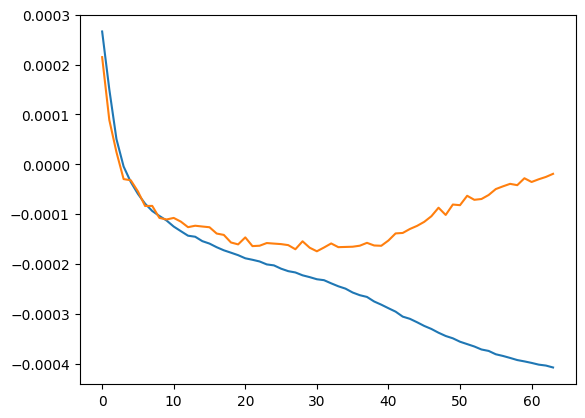

In [9]:
plt.plot(log);
# eval(model, test_loader, criterion, ssl = True), eval(model, test_loader, pearson, ssl = True)
eval(model, test_loader, criterion, ssl = True)